In [1]:
import pandas as pd
import zipfile
from langdetect import detect
import warnings
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings("ignore")


# Load data

In [2]:
z = zipfile.ZipFile('./data/airbnb/airbnb.zip', 'r')
z.extract("reviews.csv", "./data/airbnb/")
z = zipfile.ZipFile('./data/hotel-reviews-eu/515k-hotel-reviews-data-in-europe.zip', 'r')
z.extractall("./data/hotel-reviews-eu/")
z = zipfile.ZipFile('./data/hotel-reviews/hotel-reviews.zip', 'r')
z.extractall("./data/hotel-reviews/")

# Explore Airbnb reviews

In [3]:
airbnb_data = pd.read_csv('./data/airbnb/reviews.csv')
print('Null reviews:', sum(airbnb_data.comments.isna()))

Null reviews: 622


In [4]:
airbnb_data = airbnb_data.dropna(subset=['comments'])

In [5]:
airbnb_data.comments.describe()

count                                               1485614
unique                                              1426862
top       The host canceled this reservation 2 days befo...
freq                                                   1646
Name: comments, dtype: object

In [6]:
airbnb_data = airbnb_data.drop_duplicates(subset=['comments'])
airbnb_data['text_length'] = airbnb_data.comments.apply(len)

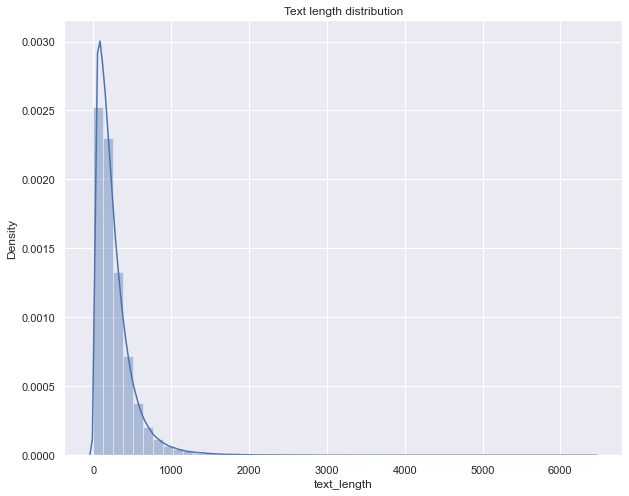

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme();


fig, ax = plt.subplots(figsize=(10,8))
chart = sns.distplot(airbnb_data['text_length'])
ax.set_title("Text length distribution")
plt.show();

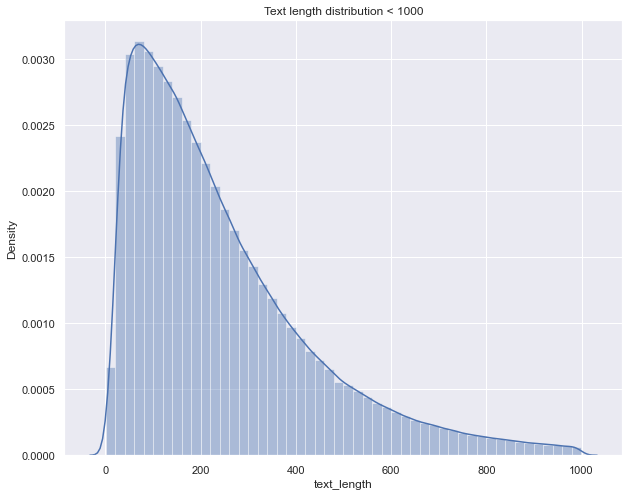

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
chart = sns.distplot(airbnb_data['text_length'][airbnb_data['text_length'] < 1000])
ax.set_title("Text length distribution < 1000")
plt.show();

In [9]:
airbnb_data = airbnb_data[airbnb_data.text_length > 10]

In [ ]:
#airbnb_data['predict_lang'] = airbnb_data.comments.apply(detect)
#print('Unique langs: \n', airbnb_data['predict_lang']).unique())

# Explore Hotel reviews data

In [4]:
hotel_data = pd.read_csv('./data/hotel-reviews/Datafiniti_Hotel_Reviews.csv')

In [5]:
hotel_data.columns

Index(['id', 'dateAdded', 'dateUpdated', 'address', 'categories',
       'primaryCategories', 'city', 'country', 'keys', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateSeen',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username',
       'sourceURLs', 'websites'],
      dtype='object')

In [6]:
hotel_data_eu = pd.read_csv('./data/hotel-reviews-eu/Hotel_Reviews.csv')
hotel_data_eu.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [7]:
hotel_data_eu.head(3)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968


In [8]:
positive_texts = hotel_data_eu['Positive_Review'].tolist()
negative_texts = hotel_data_eu['Negative_Review'].tolist()
positive_labels = [1 for i in range(len(positive_texts))]
negative_labels = [0 for i in range(len(negative_texts))]

sentiment_data = pd.DataFrame({'text': positive_texts + negative_texts, 'sentiment': positive_labels + negative_labels})
sentiment_data.dropna(subset=['text'], inplace=True)
sentiment_data['text'] = sentiment_data['text'].astype('str')
sentiment_data['text_length'] = sentiment_data.text.apply(len)
sentiment_data = sentiment_data.sample(frac=1).reset_index(drop=True)

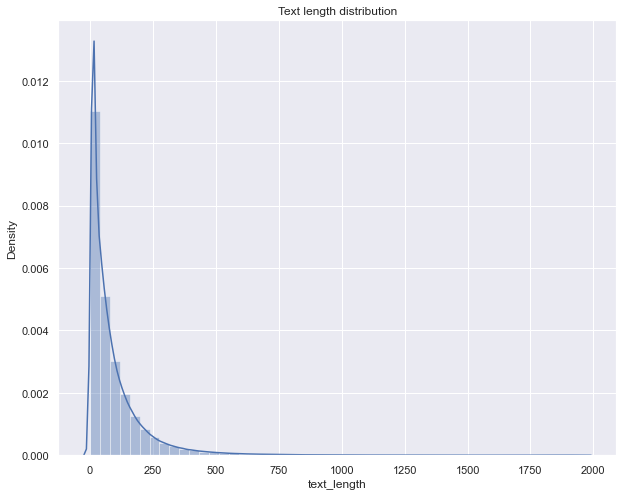

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
chart = sns.distplot(sentiment_data['text_length'])
ax.set_title("Text length distribution")
plt.show();

In [16]:
sentiment_data = sentiment_data[(sentiment_data['text_length'] < 500) &  (sentiment_data['text_length'] > 10)]

# Get sentiment with Vader Sentiment

In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
sentiment_data['score'] = sentiment_data.text.apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [28]:
from sklearn.metrics import classification_report

In [41]:
print(classification_report(sentiment_data['sentiment'], 
                            (sentiment_data['score'] > 0).astype('int')))

              precision    recall  f1-score   support

           0       0.71      0.51      0.60    468948
           1       0.63      0.80      0.70    486690

    accuracy                           0.66    955638
   macro avg       0.67      0.66      0.65    955638
weighted avg       0.67      0.66      0.65    955638



# Text preprocessing and analyzing

In [42]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [54]:
doc = nlp('This was the best played game')
[(token.lemma_, token.pos_) for token in doc]

[('this', 'DET'),
 ('be', 'AUX'),
 ('the', 'DET'),
 ('well', 'ADV'),
 ('play', 'VERB'),
 ('game', 'NOUN')]

In [51]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer

tokenizer = TweetTokenizer()
stemmer = SnowballStemmer('english')

In [67]:
import re

text = 'This was the best played game'
tokens = tokenizer.tokenize(text)
tokens1 = text.split(' ')
tokens2 = re.findall('\w+', text)
tokens == tokens1 == tokens2

True

In [68]:
tokens

['This', 'was', 'the', 'best', 'played', 'game']

In [69]:
stemmed_tokens = [stemmer.stem(w) for w in tokens]
stemmed_tokens

['this', 'was', 'the', 'best', 'play', 'game']

In [17]:
def preprocess_text(text):
    tokens = tokenizer.tokenize(text.lower())
    return [stemmer.stem(w) for w in tokens]

In [73]:
sentiment_data['tokens'] = sentiment_data.text.apply(preprocess_text)

In [75]:
all_counts = {}
positive_counts = {}
negative_counts = {}
for i, row in sentiment_data.iterrows():
    for token in row.tokens:
        if token not in all_counts:
            all_counts[token] = 1
        else:
            all_counts[token] += 1
        if row.sentiment:
            if token not in positive_counts:
                positive_counts[token] = 1
            else:
                positive_counts[token] += 1
        else:
            if token not in negative_counts:
                negative_counts[token] = 1
            else:
                negative_counts[token] += 1

In [78]:
print('50 most common tokens: \n', sorted(all_counts, key=lambda x: all_counts.get(x), reverse=True)[:50])

50 most common tokens: 
 ['the', 'and', 'was', 'room', 'to', 'a', 'veri', 'in', 'no', 'staff', 'locat', 'of', 'hotel', 'for', 'is', 'it', 'i', 'breakfast', 'were', 'negat', 'we', 'good', 'not', 'great', 'with', 'bed', 'friend', 'but', 'help', 'on', 'clean', 'at', 'nice', 't', 'from', 'comfort', 'had', 'have', 'excel', 'stay', 'be', 'that', 'small', 'you', 'as', 'so', 'there', 'love', 'all', 'are']


In [79]:
print('50 most common tokens in positive: \n', sorted(positive_counts, key=lambda x: positive_counts.get(x), reverse=True)[:50])

50 most common tokens in positive: 
 ['the', 'and', 'was', 'staff', 'locat', 'veri', 'room', 'to', 'a', 'hotel', 'good', 'great', 'in', 'of', 'is', 'friend', 'were', 'breakfast', 'help', 'for', 'nice', 'clean', 'comfort', 'bed', 'excel', 'with', 'we', 'it', 'i', 'love', 'no', 'posit', 'stay', 'from', 'at', 'close', 'on', 'station', 'all', 'walk', 'are', 'but', 'our', 'perfect', 'realli', 'servic', 'you', 'everyth', 'restaur', 'so']


In [80]:
print('50 most common tokens in negative: \n', sorted(negative_counts, key=lambda x: negative_counts.get(x), reverse=True)[:50])

50 most common tokens in negative: 
 ['the', 'was', 'no', 'a', 'room', 'to', 'and', 'in', 'negat', 'not', 'of', 'for', 'it', 'i', 'veri', 'we', 'is', 'but', 'hotel', 't', 'on', 'breakfast', 'have', 'at', 'were', 'small', 'had', 'be', 'that', 'with', 'there', 'as', 'from', 'bed', 'staff', 'you', 'so', 'they', 'could', 'my', 'this', 'too', 'bit', 'would', 'our', 'bathroom', 'are', 'onli', 'night', 'all']


In [81]:
pos_token_probability = {token: positive_counts[token] / all_counts[token] for token in positive_counts}
print('50 most probable tokens in positive: \n', sorted(pos_token_probability, key=lambda x: pos_token_probability.get(x), reverse=True)[:50])

50 most probable tokens in positive: 
 ['aniko', 'spearmint', 'winemak', 'seemless', 'locstion', 'kike', 'floorwarm', 'atmosf', 'carolina', 'cnr', 'phil', 'foosbal', 'babyfoot', 'drinkl', 'excelsnt', 'universitat', 'rampla', 'zoe', 'urquiola', 'hani', 'exepri', '06h40', 'boi', 'bolong', 'westbahnhoff', 'recommendatiion', 'keft', '3teabag', 'sergi', 'meia', 'cerverseria', 'catalana', 'stephansplaz', 'ahom', 'detfin', 'stylis', 'chani', 'famtast', 'liliya', 'palladium', 'locationi', 'pompidou', 'everythijf', 'gerard', 'pleasnt', 'bargin', 'identikit', 'orienr', 'fatast', 'mauric']


In [84]:
pos_token_probability = {token: prob for token, prob in pos_token_probability.items() if prob < 0.9}
print('50 most probable tokens in positive: \n', sorted(pos_token_probability, key=lambda x: pos_token_probability.get(x), reverse=True)[:50])

50 most probable tokens in positive: 
 ['baker', 'chic', 'stadium', 'dome', 'embassi', 'sleek', 'galleria', 'wembley', 'pleasant', 'tremend', 'proffession', 'comfiest', 'waitros', 'emplac', 'sizabl', 'blvd', 'piazza', 'julia', 'leo', 'polo', 'latino', 'vincent', 'swanki', 'tidi', 'effici', 'olymp', 'repubblica', 'conscienti', 'vineyard', 'cadorna', 'madelin', '57th', 'christoph', 'bespok', 'hardwork', 'chris', 'kew', 'hungarian', 'mike', 'coveni', 'vanessa', 'handwritten', 'silent', 'gard', 'seamless', 'bush', 'spectacular', 'las', 'rambla', 'tottenham']


In [86]:
neg_token_probability = {token: negative_counts[token] / all_counts[token] for token in negative_counts}
neg_token_probability = {token: prob for token, prob in neg_token_probability.items() if prob < 0.9}
print('50 most probable tokens in negative: \n', sorted(neg_token_probability, key=lambda x: neg_token_probability.get(x), reverse=True)[:50])

50 most probable tokens in negative: 
 ['tight', 'apolog', 'prevent', 'frame', 'concret', 'appar', 'sex', 'fray', 'indic', 'mug', 'neither', 'wast', 'earplug', 'dark', '170', 'tear', 'fatti', 'switch', 'should', 'bug', 'hook', 'unblock', 'disgrac', '209', 'softer', 'abit', 'paint', 'wateri', 'forc', 'tile', 'corridor', 'unless', 'interv', 'smokey', 'recess', 'pinch', 'insist', 'neck', 'scari', 'flow', 'neighbor', 'dissapoint', 'pointless', 'stool', 'manoeuvr', 'unhappi', 'net', 'stench', 'tooooo', 'spg']


# Model training

In [12]:
from sklearn.model_selection import train_test_split
sentiment_data = sentiment_data.sample(frac=0.4)
train_texts, test_texts, train_labels, test_labels = train_test_split(sentiment_data['text'], sentiment_data['sentiment'], test_size=0.2)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(analyzer='word', ngram_range=(1,1), max_features=15000, max_df=0.8, min_df=2)
vec.fit(train_texts)
X_train = vec.transform(train_texts)
X_test = vec.transform(test_texts)

In [14]:
vec.vocabulary_

{'no': 8465,
 'negative': 8361,
 'good': 5746,
 'breakfast': 2006,
 'friendly': 5450,
 'and': 991,
 'helpful': 6139,
 'staff': 11811,
 'everything': 4744,
 'worked': 13981,
 'well': 13784,
 'when': 13839,
 'first': 5166,
 'arriving': 1194,
 'the': 12566,
 'view': 13543,
 'of': 8649,
 'front': 5470,
 'hotel': 6317,
 'looked': 7494,
 'little': 7405,
 'dated': 3622,
 'didn': 3910,
 'replicate': 10349,
 'what': 13827,
 'interior': 6746,
 'was': 13694,
 'like': 7336,
 'from': 5467,
 'moment': 8123,
 'you': 14074,
 'walked': 13643,
 'through': 12654,
 'door': 4176,
 'parking': 9024,
 'available': 1365,
 'for': 5328,
 'guests': 5909,
 'at': 1269,
 'is': 6836,
 'free': 5410,
 'charge': 2538,
 'in': 6505,
 'entire': 4616,
 '19': 138,
 'district': 4108,
 'but': 2207,
 'may': 7821,
 'be': 1583,
 'very': 13515,
 'difficult': 3925,
 'to': 12739,
 'find': 5136,
 'as': 1217,
 'streets': 12040,
 'around': 1181,
 'are': 1149,
 'tightly': 12695,
 'packed': 8933,
 'with': 13940,
 'cars': 2377,
 'also': 9

In [22]:
train_texts.values[2]

' When first arriving the view of the front of the hotel looked a little dated and didn t replicate what the interior was like from the moment you walked through the the door '

In [23]:
text_features = X_train[2].toarray()[0]
text_features

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
import numpy as np 


ind2tokens = {ind: token for token, ind in vec.vocabulary_.items()}
important_token_inds = np.argsort(text_features)[::-1][:3]
print('Most important features in text: \n', [ind2tokens[i] for i in important_token_inds])

Most important features in text: 
 ['the', 'replicate', 'moment']


In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=0.1, solver='sag')
model.fit(X_train, train_labels)

LogisticRegression(C=0.1, solver='sag')

In [29]:
preds = model.predict(X_test)
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     16510
           1       0.96      0.92      0.94     16498

    accuracy                           0.94     33008
   macro avg       0.94      0.94      0.94     33008
weighted avg       0.94      0.94      0.94     33008



In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rnf = RandomForestClassifier(n_estimators=100)
rnf.fit(X_train, train_labels)

RandomForestClassifier()

In [31]:
preds = rnf.predict(X_test)
f1_score(test_labels, preds)

0.9426179041989903

In [32]:
feature_importance = rnf.feature_importances_
most_important = feature_importance.argsort()[::-1][:10]

[(ind2tokens[ind], feature_importance[ind]) for ind in most_important]

[('no', 0.06428920913278521),
 ('location', 0.06325332092316137),
 ('negative', 0.043949761538573336),
 ('staff', 0.031181173561860218),
 ('positive', 0.028874370921304817),
 ('and', 0.026478415376312257),
 ('great', 0.022923309357817733),
 ('not', 0.02075259210672495),
 ('good', 0.01994883358430946),
 ('nothing', 0.01808913342277193)]

In [33]:

best_score = 0
for tol in [1e-2, 1e-3, 1e-4]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        for solver in ['sag', 'liblinear', 'lbfgs']:
            logreg = LogisticRegression(C=C, tol=tol, solver=solver)
            logreg.fit(X_train, train_labels)
            preds = logreg.predict(X_test)
            f1 = f1_score(test_labels, preds)
            # if we got a better score, store the score and parameters
            if f1 > best_score:
                best_score = f1
                best_parameters = logreg.get_params()

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Best score: 0.94
Best parameters: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'sag', 'tol': 0.01, 'verbose': 0, 'warm_start': False}


# Try something else

###### DATA INFO ######

### TEXT LENGTH ###

Total number of samples: 123414
Classname: sentiment

### TEXT LENGTH ###

count    123414.000000
mean        121.934481
std         142.951683
min           1.000000
25%          42.000000
50%          78.000000
75%         148.000000
max        1953.000000
Name: text, dtype: float64

#################


TRY TO USE remove_outliers() METHOD


#################

### SENTIMENT ###

Num classes: 2

Class 0: 0

Class 1: 1


#################


### DATA HEAD ###

   sentiment                                               text
0          0   I had no hot water in my room for the 2 night...
1          1   The staff was very pleasant and upgraded our ...
2          1   We particularly liked the overall quality of ...
3          0                   The bed can be more comfortable 
4          1                Amazon breakfast and friendly staff
5          0   Nice design is not always pratical shower and...
6          0                        Bed cou

'Data prepared for train'

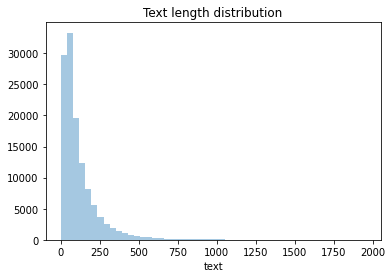

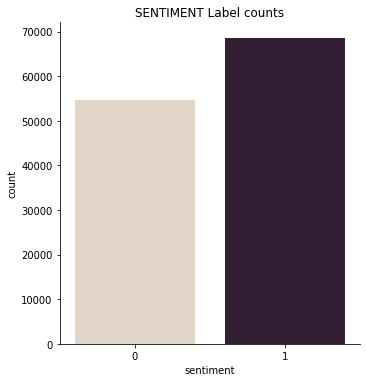

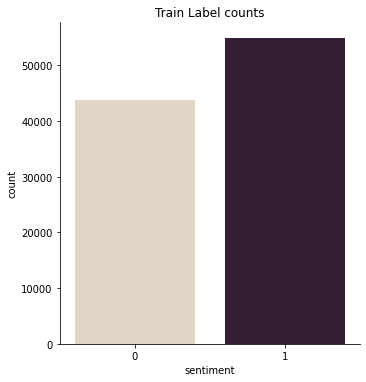

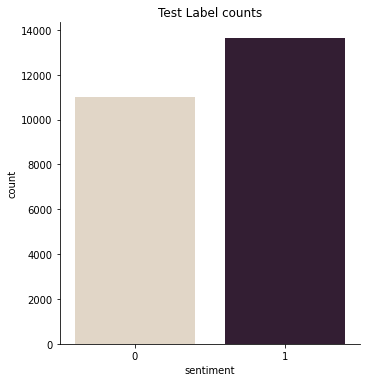

In [34]:
from auto_classifier.common import DataProcessor
regex = [r'(@|#)(\w+)', r'[(RT_:)|(RT:)]'] # rexexp for cleaning.
data = DataProcessor(data=sentiment_data,
                     class_column_name='sentiment')
data.load_data()
data.prepare(regex, test_size=0.2)

In [35]:
from auto_classifier.models import AutoLinearModel
from auto_classifier.common import AutoClassifier
from sklearn.metrics import f1_score

auto_classifier = AutoClassifier(data)
auto_classifier.params_prepare()

if data.y_train.nunique() > 2:
  from functools import partial
  score_funcs = {'f1': partial(f1_score, average='macro')}
else:
  score_funcs = {'f1': f1_score}

report = auto_classifier.get_report(metrics_dict=score_funcs)

  0%|          | 0/120 [00:00<?, ?it/s]

In [37]:
report.sort_values('f1', ascending=False)

,vectorizer,model,params,1_precision,1_recall,0_precision,0_recall,f1
14,tfidf_ngram_level,"LinearSVC(C=1, loss='hinge', tol=1e-05)","{'C': 1, 'loss': 'hinge', 'tol': 1e-05}",0.960638,0.940233,0.927915,0.952312,0.950326
12,tfidf_ngram_level,"LinearSVC(C=1, loss='hinge', tol=0.001)","{'C': 1, 'loss': 'hinge', 'tol': 0.001}",0.960638,0.940233,0.927915,0.952312,0.950326
13,tfidf_ngram_level,"LinearSVC(C=1, loss='hinge')","{'C': 1, 'loss': 'hinge', 'tol': 0.0001}",0.960638,0.940233,0.927915,0.952312,0.950326
72,supervised_ngram_level,"LinearSVC(C=1, loss='hinge', tol=0.001)","{'C': 1, 'loss': 'hinge', 'tol': 0.001}",0.960560,0.940086,0.927745,0.952221,0.950213
73,supervised_ngram_level,"LinearSVC(C=1, loss='hinge')","{'C': 1, 'loss': 'hinge', 'tol': 0.0001}",0.960560,0.940086,0.927745,0.952221,0.950213
...,...,...,...,...,...,...,...,...
29,tfidf_ngram_level,"LinearSVC(C=100, tol=1e-05)","{'C': 100, 'loss': 'squared_hinge', 'tol': 1e-05}",0.915037,0.911887,0.891397,0.895195,0.913460
27,tfidf_ngram_level,"LinearSVC(C=100, tol=0.001)","{'C': 100, 'loss': 'squared_hinge', 'tol': 0.001}",0.911379,0.915183,0.894468,0.889846,0.913277
89,supervised_ngram_level,"LinearSVC(C=100, tol=1e-05)","{'C': 100, 'loss': 'squared_hinge', 'tol': 1e-05}",0.910806,0.912473,0.891413,0.889393,0.911639
88,supervised_ngram_level,LinearSVC(C=100),"{'C': 100, 'loss': 'squared_hinge', 'tol': 0.0...",0.910207,0.912473,0.891324,0.888577,0.911339


In [39]:
auto_classifier.vectorizers['tfidf_ngram_level']

TfidfVectorizer(analyzer='char', max_df=0.7, max_features=30000,
                ngram_range=(4, 4))

# Final model

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

vectorizer = TfidfVectorizer(analyzer='char', max_df=0.7, max_features=30000,
                ngram_range=(4, 4))
vectorizer.fit(sentiment_data.text)
features = vectorizer.transform(sentiment_data.text)
svm = LinearSVC(C=1, loss='hinge')



## Cross validation

In [44]:
mean_f1 = np.mean(cross_val_score(svm, features, sentiment_data.sentiment, cv=5, scoring='f1_macro'))
print('CV f1 = ', mean_f1)

CV f1 =  0.9526692239116489


In [54]:
svm.fit(features, sentiment_data.sentiment)

LinearSVC(C=1, loss='hinge')

# Save and load model for inference

In [55]:
import joblib
joblib.dump(vectorizer, './model/vectorizer.pkl')
joblib.dump(svm, './model/svm.pkl')

['./model/svm.pkl']

In [56]:
model = joblib.load('./model/svm.pkl')
vectorizer = joblib.load('./model/vectorizer.pkl')

In [57]:
def get_predictions(texts, model, vectorizer):
    features = vectorizer.transform(texts)
    preds = model.predict(features)
    return preds

In [58]:
airbnb_data.dropna(subset=['comments'], inplace=True)

In [63]:
airbnb_data['sentiment'] = get_predictions(airbnb_data['comments'], model, vectorizer)

In [64]:
airbnb_data[airbnb_data['sentiment'] == 1].comments.values[:10]

array(['The flat was bright, comfortable and clean and Adriano was pleasant and gracious about accommodating us at the last minute. The Brixton tube was a very short walk away and there were plenty of buses. There are lots of fast food restaurants, banks, and shops along the main street.',
       "We stayed with Adriano and Valerio for a week when first moving to London. The apartment is great and very clean compared to a lot of places we've seen in London. Situated very close to Brixton tube and good bus links to central London. Thanks guys!",
       'it was all in all the perfect week!\r\nchilton is supernice, she put up flowers bouquets for us and fresh croissants were waiting for us in the kitchen when we arrived!\r\nthe apartment is sweet, the terrace is just amazing, the location is great. \r\ninternet is really fast and included.\r\nall kinds of different stores are around the area, a tube station and several bus stations.\r\n there is a great market on saturday. \r\n\r\nwe had 

In [68]:
airbnb_data[airbnb_data['sentiment'] == 0].comments.values[:10]

array(['The host canceled my reservation 4 days before arrival.',
       'My stay was fine, full of bad luck and the host did her best to remedy things.  ',
       "  I'm not sure which of us misunderstood the situation, but I was not aware that Adriano and his cousin would be in residence...I thought I was renting the apartment to myself. Nonetheless, he was a very gracious host. The neighborhood is not a good one, and anyone renting here should be aware of that. I would not walk in that area at night under any circumstances. The apartment is spotlessly clean though. ",
       'The host canceled my reservation 4 days before arrival.',
       "I highly recommend John's apartment. Clean, I enjoyed the outlet for foreigners. Too bad I could not meet John.",
       "Nous sommes restées 5 nuits et ne pouvions demander pour un meilleur endroit pour dormir durant notre séjour a Londres. Appartement propre, emplacement idéal a quelques pas du métro/de l'arrêt d'autobus. \r\n\r\nEven though we

# Word vectors

### Load pretrained word vectors (GLOVE) with gensim 

In [273]:
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-100")

In [274]:
ind2word = {index: word for index, word in enumerate(model.index2word)}
df = pd.DataFrame(model.vectors)
df.index = model.index2word
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
the,-0.038194,-0.244870,0.728120,-0.399610,0.083172,0.043953,-0.391410,0.334400,-0.57545,0.087459,...,0.016215,-0.017099,-0.389840,0.87424,-0.725690,-0.510580,-0.520280,-0.145900,0.82780,0.270620
",",-0.107670,0.110530,0.598120,-0.543610,0.673960,0.106630,0.038867,0.354810,0.06351,-0.094189,...,0.349510,-0.722600,0.375490,0.44410,-0.990590,0.612140,-0.351110,-0.831550,0.45293,0.082577
.,-0.339790,0.209410,0.463480,-0.647920,-0.383770,0.038034,0.171270,0.159780,0.46619,-0.019169,...,-0.063351,-0.674120,-0.068895,0.53604,-0.877730,0.318020,-0.392420,-0.233940,0.47298,-0.028803
of,-0.152900,-0.242790,0.898370,0.169960,0.535160,0.487840,-0.588260,-0.179820,-1.35810,0.425410,...,0.187120,-0.018488,-0.267570,0.72700,-0.593630,-0.348390,-0.560940,-0.591000,1.00390,0.206640
to,-0.189700,0.050024,0.190840,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.20135,0.342410,...,-0.131340,0.058617,-0.318690,-0.61419,-0.623930,-0.415480,-0.038175,-0.398040,0.47647,-0.159830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chanty,-0.155770,-0.049188,-0.064377,0.223600,-0.201460,-0.038963,0.129710,-0.294510,0.00359,-0.098377,...,0.093324,0.094486,-0.023469,-0.48099,0.623320,0.024318,-0.275870,0.075044,-0.56380,0.145010
kronik,-0.094426,0.147250,-0.157390,0.071966,-0.298450,0.039432,0.021870,0.008041,-0.18682,-0.311010,...,-0.305450,-0.011082,0.118550,-0.11312,0.339510,-0.224490,0.257430,0.631430,-0.20090,-0.105420
rolonda,0.360880,-0.169190,-0.327040,0.098332,-0.429700,-0.188740,0.455560,0.285290,0.30340,-0.366830,...,-0.044082,0.140030,0.300070,-0.12731,-0.143040,-0.069396,0.281600,0.271390,-0.29188,0.161090
zsombor,-0.104610,-0.504700,-0.493310,0.135160,-0.363710,-0.447500,0.184290,-0.056510,0.40474,-0.725830,...,0.151530,-0.108420,0.340640,-0.40916,-0.081263,0.095315,0.150180,0.425270,-0.51250,-0.170540


## PCA (principal component analysis) for word vectors visualization

### Метод главных компонент

In [275]:
# Make correlation matrix for word embeddings
X_corr = df.corr()
X_corr

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.047752,-0.014292,0.044700,-0.009530,0.033023,0.040900,0.020097,-0.038278,-0.008330,...,-0.014188,0.034891,0.040719,-0.070926,-0.002997,-0.056472,-0.045578,0.087672,-0.031889,-0.055502
1,0.047752,1.000000,0.130477,0.008114,-0.051977,0.151987,-0.025333,-0.021641,-0.104307,0.079012,...,-0.117549,0.125206,-0.073654,-0.111820,-0.090184,-0.123236,-0.042834,-0.035777,0.144126,0.006808
2,-0.014292,0.130477,1.000000,-0.013003,-0.034764,0.142814,-0.080159,0.127775,-0.081219,0.094234,...,-0.037049,0.067761,-0.151169,0.005255,-0.137425,0.023695,-0.038352,-0.067774,0.210181,-0.003648
3,0.044700,0.008114,-0.013003,1.000000,-0.002380,0.040784,0.016448,0.014086,0.041541,0.034399,...,-0.011076,0.050719,0.027574,-0.018850,0.033951,0.065447,0.039158,0.118349,0.006300,-0.036766
4,-0.009530,-0.051977,-0.034764,-0.002380,1.000000,-0.038139,-0.043462,0.001065,0.042857,0.044330,...,0.096816,-0.096095,-0.035090,-0.040948,-0.070540,0.067642,-0.024426,0.030826,-0.004293,-0.008960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.056472,-0.123236,0.023695,0.065447,0.067642,-0.040999,-0.041249,0.082459,0.001216,-0.002528,...,0.098509,-0.043212,0.045143,0.002824,-0.010348,1.000000,0.038308,0.053798,-0.015721,-0.005783
96,-0.045578,-0.042834,-0.038352,0.039158,-0.024426,-0.070415,-0.029299,0.007408,0.005033,-0.008146,...,0.012715,0.073663,0.029527,0.019142,0.055921,0.038308,1.000000,0.090420,-0.051634,0.004805
97,0.087672,-0.035777,-0.067774,0.118349,0.030826,-0.009450,0.015286,0.059896,0.020882,-0.018379,...,0.014602,0.037746,0.003576,-0.077470,0.012669,0.053798,0.090420,1.000000,-0.004390,0.014955
98,-0.031889,0.144126,0.210181,0.006300,-0.004293,0.137220,-0.019542,0.136293,-0.077173,0.122270,...,-0.102305,0.047752,-0.145636,0.039874,-0.117448,-0.015721,-0.051634,-0.004390,1.000000,0.048927


In [276]:
# Compute eigen vectors and eigen values
eig_val, eig_vectors = np.linalg.eig(X_corr)

In [277]:
eig_vectors.shape

(100, 100)

In [278]:
eig_val

array([5.42346854, 3.32760641, 2.35634348, 2.15072078, 2.08844525,
       1.70179838, 1.6351333 , 1.62441185, 1.55192982, 1.51729949,
       0.24248714, 1.44852789, 1.36829537, 0.34887939, 1.34260819,
       0.37468498, 0.40107286, 1.30512068, 0.41581047, 1.27814016,
       1.25799609, 0.4648709 , 0.47449117, 1.22426634, 1.20688861,
       1.18513159, 1.19781618, 0.49096155, 0.50347183, 0.51672501,
       0.52547096, 0.54860236, 1.14638979, 0.55589342, 0.57553277,
       0.5937076 , 0.60938926, 1.12002705, 1.1128732 , 1.10563689,
       1.09279702, 0.62397873, 1.08098937, 0.6378985 , 1.06587191,
       0.65317528, 0.65989146, 1.05427639, 1.04422431, 1.03938395,
       1.0299731 , 1.01585457, 1.01825202, 0.68486883, 0.68995893,
       0.69515523, 0.70553558, 0.7164295 , 0.72064259, 0.72504153,
       0.99237226, 0.99752305, 0.97953254, 0.97751274, 0.97543839,
       0.73998876, 0.96749855, 0.74869387, 0.95567625, 0.95765707,
       0.75062694, 0.94292699, 0.76315432, 0.93690027, 0.76960

In [279]:
# Get 2 eigen vectors that corresponds 2 max eigen values
inds_max_eig_vals = eig_val.argsort()[::-1][:2]
principal_components = eig_vectors.T[:2].T

# Get projection on principal components
X_new = np.dot(df, principal_components)
new_df = pd.DataFrame(X_new)
new_df.index = model.index2word

In [280]:
words = [ 'good', 'bad', 'awful', 'great', 'beautiful', 'ugly', 'positive', 'negative', 'worst', 'best', 'negative', 'room', 'house', 'mother', 'mum']


In [281]:
import seaborn as sns
import matplotlib.pyplot as plt


def scatter_text(x, y, data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 9))
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.01, data[y][line], 
                 data.index[line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
   
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    

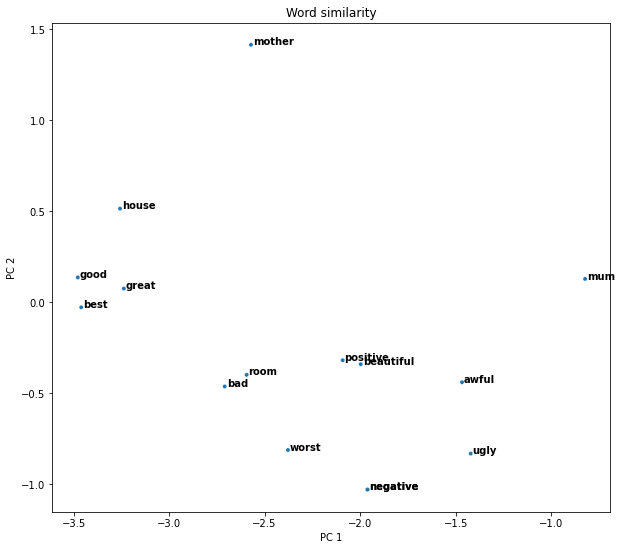

In [282]:
scatter_text(0, 1,  new_df.loc[words], 'Word similarity', 'PC 1', 'PC 2');

## Similarity of word vectors

In [283]:
model.most_similar('room')

[('rooms', 0.8417543172836304),
 ('floor', 0.8001206517219543),
 ('bedroom', 0.7659991979598999),
 ('door', 0.7539053559303284),
 ('inside', 0.7500433921813965),
 ('filled', 0.7457945942878723),
 ('bathroom', 0.7396396398544312),
 ('upstairs', 0.7388455867767334),
 ('window', 0.736920177936554),
 ('basement', 0.7362379431724548)]

In [284]:
model.most_similar('hotel')

[('hotels', 0.7933705449104309),
 ('restaurant', 0.7762866020202637),
 ('apartment', 0.7356935143470764),
 ('inn', 0.7277153730392456),
 ('resort', 0.7140624523162842),
 ('motel', 0.7057352066040039),
 ('mansion', 0.7018170952796936),
 ('room', 0.6931589245796204),
 ('dining', 0.6926475763320923),
 ('hilton', 0.6836727261543274)]

In [285]:
model.most_similar('good')

[('better', 0.893191397190094),
 ('sure', 0.8314563035964966),
 ('really', 0.8297762274742126),
 ('kind', 0.828826904296875),
 ('very', 0.8260800838470459),
 ('we', 0.8234355449676514),
 ('way', 0.8215397596359253),
 ('think', 0.8205099105834961),
 ('thing', 0.8171302080154419),
 ("'re", 0.8141680955886841)]

## Word vectors arithmetic

In [302]:
vec = model.get_vector('paris') - model.get_vector('france') + model.get_vector('german')
model.similar_by_vector(vec)[1:]

[('berlin', 0.7070452570915222),
 ('frankfurt', 0.6412850618362427),
 ('austrian', 0.6265485286712646),
 ('vienna', 0.5965505838394165),
 ('paris', 0.5947260856628418),
 ('swiss', 0.5900634527206421),
 ('munich', 0.5846803188323975),
 ('hamburg', 0.5777071714401245),
 ('polish', 0.5746312737464905)]

In [303]:
vec = model.get_vector('king') - model.get_vector('man') + model.get_vector('woman')
model.similar_by_vector(vec)[1:]

[('queen', 0.783441424369812),
 ('monarch', 0.6933802366256714),
 ('throne', 0.6833109855651855),
 ('daughter', 0.680908203125),
 ('prince', 0.6713142395019531),
 ('princess', 0.664408266544342),
 ('mother', 0.6579325199127197),
 ('elizabeth', 0.6563301086425781),
 ('father', 0.6392419338226318)]

In [306]:
vec = model.get_vector('beautiful') - model.get_vector('good') + model.get_vector('bad')
model.similar_by_vector(vec)[1:]

[('gorgeous', 0.7244653105735779),
 ('lovely', 0.68180251121521),
 ('ugly', 0.6471104025840759),
 ('bad', 0.631088137626648),
 ('strange', 0.6281915903091431),
 ('scary', 0.6141659021377563),
 ('weird', 0.6127748489379883),
 ('charming', 0.6119987964630127),
 ('crazy', 0.6107257604598999)]